# 参数配置

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# transforms
train_transforms = transforms.Compose([
                                    #transforms.RandomRotation(30),
#                                        transforms.RandomResizedCrop(224),
                                       # transforms.RandomHorizontalFlip(),
                                        transforms.Resize(32),
#                                         transforms.CenterCrop(32),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.5,], [0.5,])]) # mean, std
 

test_transforms = transforms.Compose([#transforms.Resize(255),
                                      #transforms.CenterCrop(224),
                                        transforms.Resize(32),
#                                         transforms.CenterCrop(32),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.5,], [0.5,])]) # mean, std

federated_train_loader = torch.utils.data.DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.CIFAR10('/home/raoxy/data', train=True, download=True,
                   transform=train_transforms), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=200, shuffle=True, **kwargs)


federated_test_loader = torch.utils.data.DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.CIFAR10('/home/raoxy/data', train=False, download=True,
                   transform=test_transforms), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=200, shuffle=False, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


# LeNet

In [2]:
class D_CNN(nn.Module):
    # 定义模型的构造函数
    def __init__(self):
        # 调用父类的构造函数
        super(D_CNN, self).__init__()
        # 定义激活函数为Sigmoid
        act = nn.Sigmoid
        # 定义模型的卷积部分，包括四个卷积层和两个池化层，以及Sigmoid激活函数
        self.body = nn.Sequential(
            # 第一个卷积层，输入通道为3，输出通道为12，卷积核大小为5，填充为2，步长为2
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            # 第一个激活层，使用Sigmoid函数
            act(),
            # 第二个卷积层，输入通道为12，输出通道为12，卷积核大小为5，填充为2，步长为2
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            # 第二个激活层，使用Sigmoid函数
            act(),
            # 第三个卷积层，输入通道为12，输出通道为12，卷积核大小为5，填充为2，步长为1
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            # 第三个激活层，使用Sigmoid函数
            act(),
            # 第四个卷积层，输入通道为12，输出通道为12，卷积核大小为5，填充为2，步长为1
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            # 第四个激活层，使用Sigmoid函数
            act(),
        )
        # 定义模型的全连接部分，包括一个线性层
        self.fc = nn.Sequential(
            # 第一个线性层，输入特征为768，输出特征为10，表示10个类别
            nn.Linear(768, 10),
            # 注释掉了第二个激活层和第二个线性层，可能是为了简化模型
            #act(),
            #nn.Linear(256, 10)
        )
        
    # 定义模型的前向传播函数
    def forward(self, x):
        # 将输入数据通过卷积部分，得到输出
        out = self.body(x)
        # 将输出展平为一维向量，形状为(N, 768)，其中N是批量大小
        feature = out.view(out.size(0), -1)
        # 打印特征的形状，用于调试
        #print(feature.size())
        # 将特征通过全连接部分，得到最终的输出
        out = self.fc(feature)
        # 返回输出和特征
        return out, feature

In [3]:
model = D_CNN().to(device)
from torchsummary import summary
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 16, 16]             912
           Sigmoid-2           [-1, 12, 16, 16]               0
            Conv2d-3             [-1, 12, 8, 8]           3,612
           Sigmoid-4             [-1, 12, 8, 8]               0
            Conv2d-5             [-1, 12, 8, 8]           3,612
           Sigmoid-6             [-1, 12, 8, 8]               0
            Conv2d-7             [-1, 12, 8, 8]           3,612
           Sigmoid-8             [-1, 12, 8, 8]               0
            Linear-9                   [-1, 10]           7,690
Total params: 19,438
Trainable params: 19,438
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.07
Estimated Total Size (MB): 0.17
---------------------------------------------

In [4]:
def cross_entropy_for_onehot(pred, target):
    # 对预测值进行log_softmax操作，然后与目标值相乘，再求和，最后求平均
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

In [5]:
criterion =  nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.002,momentum=0.9) # TODO momentum is not supported at the moment

In [6]:
loss_test=[]
acc_test=[]
def test(model, device, federated_test_loader, batch_size):
    global criterion,txt,loss_test,acc_test
    model.eval()
    test_loss = 0
    correct = 0
    n=0
    with torch.no_grad():
        for data, target in federated_test_loader:
#             model.send(data.location) # <-- NEW: send the model in virtual workers to Trusted Aggregator
            ##########################################################################
#             target = target.to(device) 
#             data=compress_channel(data, 28)
#             optimizer.zero_grad()
#             output = model(data.to(device))
            ##########################################################################
            data, target = data.to(device), target.to(device)
            output, feature_fc1_graph = model(data)
            #########################################################################
            n += target.shape[0]
            loss = criterion(output, target.long())
#             loss = F.nll_loss(output, target, reduction='sum')
#             model.get()
#             test_loss += loss.get() # sum up batch loss
            test_loss += loss.item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            # print("{}\t{}".format(correct,target.shape))

    test_loss /= len(federated_test_loader)
    loss_test.append(test_loss)
    acc_test.append(correct*1.0/n)

    print('\tTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(federated_test_loader) * batch_size,
        100. * correct / n))

In [7]:
import numpy as np

loss_train=[]
acc_train=[]

def train(model, device, federated_train_loader, optimizer, epoch, batch_size):
    global out,target,criterion,loss_train,acc_train,deviation_f1_x_norm_sum,thresh,deviation_f1_x_norm,feature_fc1_graph
    model.train()
    train_loss = 0
    correct = 0
    n=0
    epsilon=1
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        target = target.to(device) 
        data.requires_grad = True
        out, feature_fc1_graph = model(data.to(device))

        deviation_f1_target = torch.zeros_like(feature_fc1_graph) # 创建一个全零的张量，用于存储目标梯度
        deviation_f1_x_norm = torch.zeros_like(feature_fc1_graph) # 创建一个全零的张量，用于存储导数的范数
        
        for f in range(deviation_f1_x_norm.size(1)): # 对于每个特征向量的维度
            deviation_f1_target[:,f] = 1 # 将目标梯度的对应位置设为1
            feature_fc1_graph.backward(deviation_f1_target, retain_graph=True) # 对特征向量进行反向传播，计算梯度
            deviation_f1_x = data.grad.data # 获取输入的梯度
            deviation_f1_x = deviation_f1_x.to(device) # 获取输入的梯度
            deviation_f1_x_norm[:,f] = torch.norm(deviation_f1_x.view(deviation_f1_x.size(0), -1), dim=1)/ torch.where(feature_fc1_graph[:, f] == 0, torch.ones_like(feature_fc1_graph[:, f]), feature_fc1_graph[:, f])
            model.zero_grad() # 清零网络的梯度
            data.grad.data.zero_() # 清零输入的梯度
            deviation_f1_target[:,f] = 0 # 将目标梯度的对应位置设为0

        deviation_f1_x_norm_sum = deviation_f1_x_norm.sum(axis=0) # 对每个维度求和
        thresh = np.percentile(deviation_f1_x_norm_sum.flatten().cpu().detach().numpy(), epsilon) # 根据百分位数确定阈值
        mask = np.where(abs(deviation_f1_x_norm_sum.cpu()) < thresh, 0, 1).astype(np.float32)
        
        ################################################################
        n += target.shape[0]
        y = criterion(out, target.long())
        y.backward(retain_graph=True)
        
        dy_dx = torch.autograd.grad(y, model.parameters()) # 计算损失对网络参数的梯度
        original_dy_dx = list((_.detach().clone() for _ in dy_dx)) # 复制梯度
        
        # differential privacy (DP)
        for i in range(len(original_dy_dx)):
            grad_tensor = original_dy_dx[i].cpu().numpy() # 将梯度转换为numpy数组
            mean = 0
            std = 0.1
            noise = np.random.normal(mean, std, size=grad_tensor.shape)

        #     noise = np.random.laplace(0,1e-1, size=grad_tensor.shape) # 生成拉普拉斯噪声DP-Laplace
            grad_tensor = grad_tensor + noise # 将梯度加上噪声
            original_dy_dx[i] = torch.Tensor(grad_tensor).to(device) # 将梯度转换为张量
        
        optimizer.step()
        pred = out.argmax(1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss+=y.item()

    train_loss /= len(federated_train_loader)
    loss_train.append(train_loss)
    acc_train.append(correct*1.0/ n)

    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(train_loss, correct, len(federated_train_loader) * batch_size,100.*correct / n))

# train(model, device, federated_train_loader, optimizer, 50, batch_size=200)

In [8]:
# test(model, device, federated_test_loader, batch_size=200)

# 训练

In [9]:
for epoch in range(50):
    train(model, device, federated_train_loader, optimizer, epoch, batch_size=200)
    test(model, device, federated_test_loader, batch_size=200)

Train set: Average loss: 2.2327, Accuracy: 6963/50000 (14%)
	Test set: Average loss: 1.9971, Accuracy: 2687/10000 (27%)
Train set: Average loss: 1.9476, Accuracy: 14239/50000 (28%)
	Test set: Average loss: 1.8850, Accuracy: 3150/10000 (32%)
Train set: Average loss: 1.8591, Accuracy: 16247/50000 (32%)
	Test set: Average loss: 1.8051, Accuracy: 3459/10000 (35%)
Train set: Average loss: 1.7828, Accuracy: 17872/50000 (36%)
	Test set: Average loss: 1.7345, Accuracy: 3757/10000 (38%)
Train set: Average loss: 1.7125, Accuracy: 19151/50000 (38%)
	Test set: Average loss: 1.6711, Accuracy: 3982/10000 (40%)
Train set: Average loss: 1.6470, Accuracy: 20316/50000 (41%)
	Test set: Average loss: 1.6124, Accuracy: 4166/10000 (42%)
Train set: Average loss: 1.6028, Accuracy: 21100/50000 (42%)
	Test set: Average loss: 1.5751, Accuracy: 4347/10000 (43%)
Train set: Average loss: 1.5668, Accuracy: 21843/50000 (44%)
	Test set: Average loss: 1.5378, Accuracy: 4434/10000 (44%)
Train set: Average loss: 1.5337, 

In [1]:
a='''Train set: Average loss: 2.2327, Accuracy: 6963/50000 (14%)
	Test set: Average loss: 1.9971, Accuracy: 2687/10000 (27%)
Train set: Average loss: 1.9476, Accuracy: 14239/50000 (28%)
	Test set: Average loss: 1.8850, Accuracy: 3150/10000 (32%)
Train set: Average loss: 1.8591, Accuracy: 16247/50000 (32%)
	Test set: Average loss: 1.8051, Accuracy: 3459/10000 (35%)
Train set: Average loss: 1.7828, Accuracy: 17872/50000 (36%)
	Test set: Average loss: 1.7345, Accuracy: 3757/10000 (38%)
Train set: Average loss: 1.7125, Accuracy: 19151/50000 (38%)
	Test set: Average loss: 1.6711, Accuracy: 3982/10000 (40%)
Train set: Average loss: 1.6470, Accuracy: 20316/50000 (41%)
	Test set: Average loss: 1.6124, Accuracy: 4166/10000 (42%)
Train set: Average loss: 1.6028, Accuracy: 21100/50000 (42%)
	Test set: Average loss: 1.5751, Accuracy: 4347/10000 (43%)
Train set: Average loss: 1.5668, Accuracy: 21843/50000 (44%)
	Test set: Average loss: 1.5378, Accuracy: 4434/10000 (44%)
Train set: Average loss: 1.5337, Accuracy: 22423/50000 (45%)
	Test set: Average loss: 1.5230, Accuracy: 4554/10000 (46%)
Train set: Average loss: 1.5067, Accuracy: 22827/50000 (46%)
	Test set: Average loss: 1.5038, Accuracy: 4601/10000 (46%)
Train set: Average loss: 1.4787, Accuracy: 23479/50000 (47%)
	Test set: Average loss: 1.4613, Accuracy: 4787/10000 (48%)
Train set: Average loss: 1.4544, Accuracy: 23931/50000 (48%)
	Test set: Average loss: 1.4408, Accuracy: 4845/10000 (48%)
Train set: Average loss: 1.4347, Accuracy: 24308/50000 (49%)
	Test set: Average loss: 1.4237, Accuracy: 4882/10000 (49%)
Train set: Average loss: 1.4201, Accuracy: 24529/50000 (49%)
	Test set: Average loss: 1.4297, Accuracy: 4864/10000 (49%)
Train set: Average loss: 1.4010, Accuracy: 25004/50000 (50%)
	Test set: Average loss: 1.4001, Accuracy: 4977/10000 (50%)
Train set: Average loss: 1.3856, Accuracy: 25135/50000 (50%)
	Test set: Average loss: 1.4038, Accuracy: 5025/10000 (50%)
Train set: Average loss: 1.3735, Accuracy: 25490/50000 (51%)
	Test set: Average loss: 1.3786, Accuracy: 5078/10000 (51%)
Train set: Average loss: 1.3595, Accuracy: 25722/50000 (51%)
	Test set: Average loss: 1.3646, Accuracy: 5126/10000 (51%)
Train set: Average loss: 1.3472, Accuracy: 25885/50000 (52%)
	Test set: Average loss: 1.3648, Accuracy: 5123/10000 (51%)
Train set: Average loss: 1.3368, Accuracy: 26092/50000 (52%)
	Test set: Average loss: 1.3482, Accuracy: 5199/10000 (52%)
Train set: Average loss: 1.3231, Accuracy: 26370/50000 (53%)
	Test set: Average loss: 1.3439, Accuracy: 5212/10000 (52%)
Train set: Average loss: 1.3129, Accuracy: 26472/50000 (53%)
	Test set: Average loss: 1.3311, Accuracy: 5264/10000 (53%)
Train set: Average loss: 1.3033, Accuracy: 26692/50000 (53%)
	Test set: Average loss: 1.3530, Accuracy: 5123/10000 (51%)
Train set: Average loss: 1.2959, Accuracy: 26856/50000 (54%)
	Test set: Average loss: 1.3189, Accuracy: 5236/10000 (52%)
Train set: Average loss: 1.2804, Accuracy: 27185/50000 (54%)
	Test set: Average loss: 1.2989, Accuracy: 5362/10000 (54%)
Train set: Average loss: 1.2740, Accuracy: 27222/50000 (54%)
	Test set: Average loss: 1.2974, Accuracy: 5390/10000 (54%)
Train set: Average loss: 1.2662, Accuracy: 27357/50000 (55%)
	Test set: Average loss: 1.3115, Accuracy: 5286/10000 (53%)
Train set: Average loss: 1.2591, Accuracy: 27402/50000 (55%)
	Test set: Average loss: 1.2862, Accuracy: 5353/10000 (54%)
Train set: Average loss: 1.2484, Accuracy: 27776/50000 (56%)
	Test set: Average loss: 1.3096, Accuracy: 5267/10000 (53%)
Train set: Average loss: 1.2428, Accuracy: 27788/50000 (56%)
	Test set: Average loss: 1.3052, Accuracy: 5300/10000 (53%)
Train set: Average loss: 1.2332, Accuracy: 27940/50000 (56%)
	Test set: Average loss: 1.2679, Accuracy: 5465/10000 (55%)
Train set: Average loss: 1.2267, Accuracy: 28163/50000 (56%)
	Test set: Average loss: 1.2596, Accuracy: 5504/10000 (55%)
Train set: Average loss: 1.2203, Accuracy: 28285/50000 (57%)
	Test set: Average loss: 1.2550, Accuracy: 5498/10000 (55%)
Train set: Average loss: 1.2109, Accuracy: 28408/50000 (57%)
	Test set: Average loss: 1.2492, Accuracy: 5490/10000 (55%)
Train set: Average loss: 1.2030, Accuracy: 28621/50000 (57%)
	Test set: Average loss: 1.2556, Accuracy: 5514/10000 (55%)
Train set: Average loss: 1.1994, Accuracy: 28632/50000 (57%)
	Test set: Average loss: 1.2453, Accuracy: 5526/10000 (55%)
Train set: Average loss: 1.1937, Accuracy: 28736/50000 (57%)
	Test set: Average loss: 1.2435, Accuracy: 5547/10000 (55%)
Train set: Average loss: 1.1867, Accuracy: 28930/50000 (58%)
	Test set: Average loss: 1.2338, Accuracy: 5559/10000 (56%)
Train set: Average loss: 1.1801, Accuracy: 29016/50000 (58%)
	Test set: Average loss: 1.2306, Accuracy: 5579/10000 (56%)
Train set: Average loss: 1.1752, Accuracy: 29144/50000 (58%)
	Test set: Average loss: 1.2468, Accuracy: 5568/10000 (56%)
Train set: Average loss: 1.1703, Accuracy: 29244/50000 (58%)
	Test set: Average loss: 1.2509, Accuracy: 5552/10000 (56%)
Train set: Average loss: 1.1653, Accuracy: 29291/50000 (59%)
	Test set: Average loss: 1.2303, Accuracy: 5575/10000 (56%)
Train set: Average loss: 1.1600, Accuracy: 29321/50000 (59%)
	Test set: Average loss: 1.2223, Accuracy: 5595/10000 (56%)
Train set: Average loss: 1.1547, Accuracy: 29553/50000 (59%)
	Test set: Average loss: 1.2290, Accuracy: 5602/10000 (56%)
Train set: Average loss: 1.1522, Accuracy: 29639/50000 (59%)
	Test set: Average loss: 1.2127, Accuracy: 5644/10000 (56%)
Train set: Average loss: 1.1441, Accuracy: 29753/50000 (60%)
	Test set: Average loss: 1.2022, Accuracy: 5686/10000 (57%)
Train set: Average loss: 1.1412, Accuracy: 29736/50000 (59%)
	Test set: Average loss: 1.2128, Accuracy: 5667/10000 (57%)
Train set: Average loss: 1.1396, Accuracy: 29718/50000 (59%)
	Test set: Average loss: 1.2139, Accuracy: 5653/10000 (57%)
Train set: Average loss: 1.1307, Accuracy: 29959/50000 (60%)
	Test set: Average loss: 1.2102, Accuracy: 5659/10000 (57%)
Train set: Average loss: 1.1251, Accuracy: 30041/50000 (60%)
	Test set: Average loss: 1.1966, Accuracy: 5703/10000 (57%)'''

In [2]:
# 导入需要的库
import pandas as pd

# 定义要写入的csv文件名
file = "/home/raoxy/iov-fl/file/DP-Gaussian_CIFAR10.csv"

# 定义一个空的列表，用于存储每一行的数据
loss_train=[]
loss_test=[]
acc_train=[]
acc_test=[]
# 按换行符分割数据字符串，得到每一行的字符串
lines = a.split("\n")

# 遍历每一行的字符串
for line in lines:
    # 去掉字符串两端的空格
    line = line.strip()
    # 如果字符串不为空
    if 'Train' in line:
        values = line.split()
        loss_train.append(float(values[4].split(',')[0]))
        acc_train.append(float(values[-2].split('/')[0])/float(values[-2].split('/')[1]))
    if 'Test' in line:
        values = line.split()
        loss_test.append(float(values[4].split(',')[0]))
        acc_test.append(float(values[-2].split('/')[0])/float(values[-2].split('/')[1]))

# 将行列表转换为数据框，指定列名
data_dict = {'loss_train': loss_train, 'loss_test': loss_test, 'acc_train': acc_train,'acc_test':acc_test}
df = pd.DataFrame(data_dict)

# 将数据框写入csv文件，不保留索引
df.to_csv(file, index=False)
df

,loss_train,loss_test,acc_train,acc_test
0,2.2327,1.9971,0.13926,0.2687
1,1.9476,1.8850,0.28478,0.3150
2,1.8591,1.8051,0.32494,0.3459
3,1.7828,1.7345,0.35744,0.3757
4,1.7125,1.6711,0.38302,0.3982
5,1.6470,1.6124,0.40632,0.4166
6,1.6028,1.5751,0.42200,0.4347
7,1.5668,1.5378,0.43686,0.4434
8,1.5337,1.5230,0.44846,0.4554
9,1.5067,1.5038,0.45654,0.4601


# 分析

In [10]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
mpl.use('nbAgg')

In [11]:
# 保存模型参数
model_name="DP-Gaussian_CIFAR10"

In [12]:
import pandas as pd
df=pd.DataFrame([loss_train, loss_test, acc_train, acc_test]).T
df.columns =['loss_train', 'loss_test','acc_train','acc_test']
df.to_csv("file/{}.csv".format(model_name),index=False)
mpl.style.use('seaborn-white')

<IPython.core.display.Javascript object>


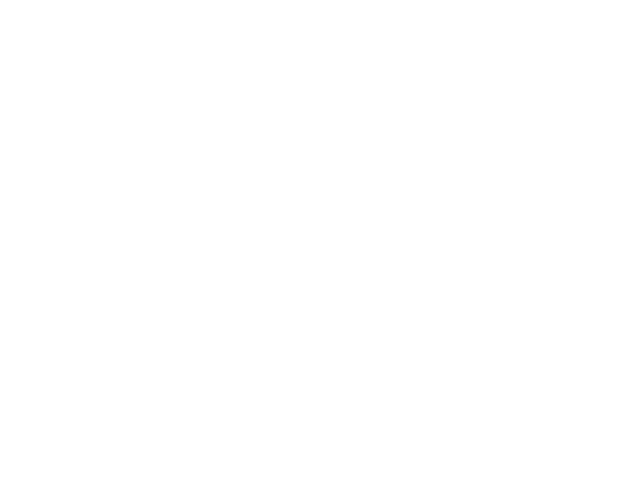

In [13]:
# 将DataFrame中的数据进行可视化，设置两个y轴
ax = df[['loss_train', 'loss_test']].plot(color=['#CD0056','#F47EAB'])
# 创建一个新的Axes对象，共享x轴
ax2 = ax.twinx()
# 绘制'acc_train'和'acc_test'在右侧y轴
df[['acc_train', 'acc_test']].plot(ax=ax2, color=['#0C755F', '#A2C69B'])
# 设置左侧y轴标签
ax.set_ylabel('Loss')
ax.set_xlabel('epoch')
# 设置右侧y轴标签
ax2.set_ylabel('Accuracy')
ax.grid(True)
ax2.grid(True)
ax.legend(loc='center')
ax2.legend(loc='center right')
# 显示图形
plt.show()

# 保存模型

In [14]:
torch.save(model.state_dict(), "{}.pth".format(model_name))
# 加载模型参数
# model = TheModelClass(*args, **kwargs) # 先定义好模型结构
# model.load_state_dict(torch.load("{}.pth".format(model_name)) # 再加载参数
# model.eval() # 设置为评估模式

In [15]:
# 保存整个模型
torch.save(model, "{}.pt".format(model_name))
# 加载整个模型
# model = torch.load("model_name.pt")
# model.eval() # 设置为评估模式

# 模型评价

In [16]:
# 导入所需的库和模块
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 定义设备，可以是 CPU 或 GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 加载MNIST数据集，并进行预处理
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

testset = torchvision.datasets.CIFAR10(root='/home/raoxy/data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = [str(i) for i in range(1,11)]

Files already downloaded and verified


In [17]:
class D_CNN(nn.Module):
    # 定义模型的构造函数
    def __init__(self):
        # 调用父类的构造函数
        super(D_CNN, self).__init__()
        # 定义激活函数为Sigmoid
        act = nn.Sigmoid
        # 定义模型的卷积部分，包括四个卷积层和两个池化层，以及Sigmoid激活函数
        self.body = nn.Sequential(
            # 第一个卷积层，输入通道为3，输出通道为12，卷积核大小为5，填充为2，步长为2
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            # 第一个激活层，使用Sigmoid函数
            act(),
            # 第二个卷积层，输入通道为12，输出通道为12，卷积核大小为5，填充为2，步长为2
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            # 第二个激活层，使用Sigmoid函数
            act(),
            # 第三个卷积层，输入通道为12，输出通道为12，卷积核大小为5，填充为2，步长为1
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            # 第三个激活层，使用Sigmoid函数
            act(),
            # 第四个卷积层，输入通道为12，输出通道为12，卷积核大小为5，填充为2，步长为1
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            # 第四个激活层，使用Sigmoid函数
            act(),
        )
        # 定义模型的全连接部分，包括一个线性层
        self.fc = nn.Sequential(
            # 第一个线性层，输入特征为768，输出特征为10，表示10个类别
            nn.Linear(768, 10),
            # 注释掉了第二个激活层和第二个线性层，可能是为了简化模型
            #act(),
            #nn.Linear(256, 10)
        )
        
    # 定义模型的前向传播函数
    def forward(self, x):
        # 将输入数据通过卷积部分，得到输出
        out = self.body(x)
        # 将输出展平为一维向量，形状为(N, 768)，其中N是批量大小
        feature = out.view(out.size(0), -1)
        # 打印特征的形状，用于调试
        #print(feature.size())
        # 将特征通过全连接部分，得到最终的输出
        out = self.fc(feature)
        # 返回输出和特征
        return out, feature

In [18]:
model = D_CNN()
model.load_state_dict(torch.load('/home/raoxy/iov-fl/DP-Laplace_CIFAR10.pth', map_location=device))
model.to(device)

D_CNN(
  (body): Sequential(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Sigmoid()
    (2): Conv2d(12, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): Sigmoid()
    (4): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Sigmoid()
    (6): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): Sigmoid()
  )
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=10, bias=True)
  )
)

In [19]:
loss_test=[]
acc_test=[]
y_true=[]
y_pred=[]
log_softmax = nn.LogSoftmax(dim=1)
def Pre(model, device, federated_test_loader, batch_size=200):
    global criterion,txt,loss_test,acc_test
    model.eval()
    test_loss = 0
    correct = 0
    n=0
    with torch.no_grad():
        for data, target in federated_test_loader:
#             model.send(data.location) # <-- NEW: send the model in virtual workers to Trusted Aggregator
            ##########################################################################
#             target = target.to(device) 
#             data=compress_channel(data, 28)
#             optimizer.zero_grad()
#             output = model(data.to(device))
            ##########################################################################
            data, target = data.to(device), target.to(device)
            output, feature_fc1_graph = model(data)
            output = log_softmax(output)
            #########################################################################
            n += target.shape[0]
            loss = criterion(output, target.long())
#             loss = F.nll_loss(output, target, reduction='sum')
#             model.get()
#             test_loss += loss.get() # sum up batch loss
            test_loss += loss.item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
#             print("{}\t{}\t{}".format(pred.shape,target.shape,accuracy_score(pred.cpu(), target.cpu())))
            y_true.extend(target.cpu().numpy())
#             print(y_true)
            y_pred.extend(pred.squeeze().cpu().numpy())

    test_loss /= len(federated_test_loader)
    loss_test.append(test_loss)
    acc_test.append(correct*1.0/n)

    print('\tTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(federated_test_loader) * batch_size,
        100. * correct / n))
    return y_true,y_pred

In [20]:
y_true,y_pred=Pre(model, device, federated_test_loader, batch_size=200)

	Test set: Average loss: 1.2056, Accuracy: 5720/10000 (57%)


In [21]:
from sklearn.metrics import accuracy_score  # pip install scikit-learn
accuracy = accuracy_score(y_true, y_pred)
print("精度: ",accuracy)

精度:  0.572


<IPython.core.display.Javascript object>


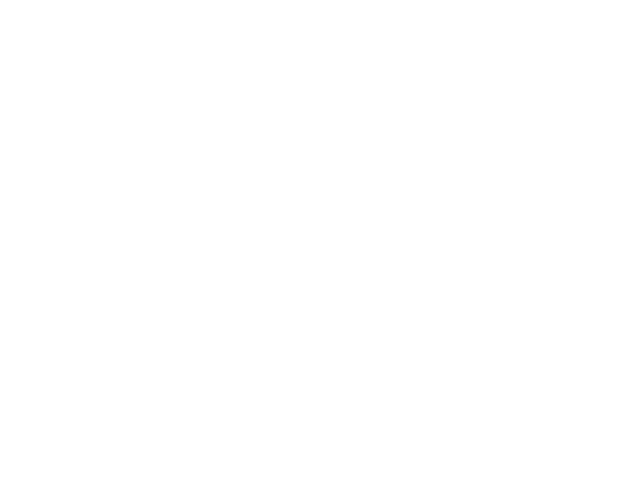

In [22]:
# 绘制混淆矩阵
confusion = confusion_matrix(y_true, y_pred)
plt.imshow(confusion, cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

<IPython.core.display.Javascript object>


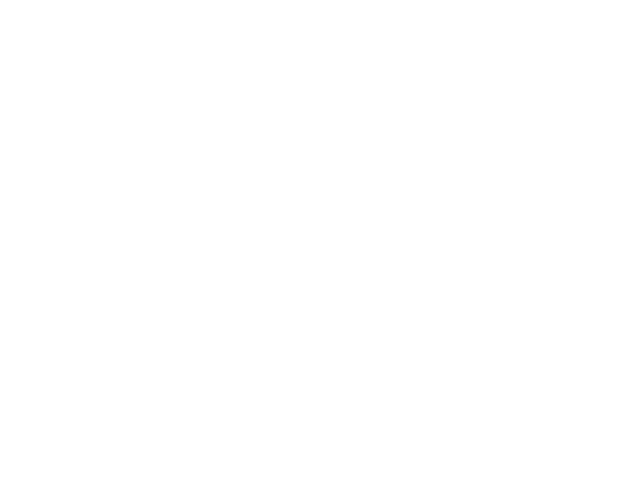

In [23]:
# 计算AUC值
y_true = np.array(y_true)
y_pred = np.array(y_pred)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制ROC曲线
plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()